## Import + Data Preparation + Tickers Choosing

In [ ]:
import sys
sys.path.append(r"/Users/nuts./Desktop/QRT/QRT")
import backtest.backtesting as bt
import backtest.backtest_results as btr
import heuristic_pf_construct # To test out the weighted strategies.
import eda_pipeline 

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Recreation of the dataset we are trying to retrieve.
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]

# What we have: data.columns is ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

data = yf.download(
    tickers=tickers,
    period="3y",          # or use start="2022-01-01", end="2025-11-26"
    interval="1d",
    group_by="ticker",    # organizes returned DataFrame by ticker first
    threads=True,
    auto_adjust=False     # keep Adj Close column rather than auto-adjusting all columns
)

adj = pd.concat({t: data[t]["Adj Close"] for t in tickers}, axis=1)
adj = eda_pipeline.eda_pipeline(adj)

[*********************100%***********************]  9 of 9 completed


In [2]:
display(data.columns)

MultiIndex([(   'UBS',      'Open'),
            (   'UBS',      'High'),
            (   'UBS',       'Low'),
            (   'UBS',     'Close'),
            (   'UBS', 'Adj Close'),
            (   'UBS',    'Volume'),
            ('BARC.L',      'Open'),
            ('BARC.L',      'High'),
            ('BARC.L',       'Low'),
            ('BARC.L',     'Close'),
            ('BARC.L', 'Adj Close'),
            ('BARC.L',    'Volume'),
            (   'BAC',      'Open'),
            (   'BAC',      'High'),
            (   'BAC',       'Low'),
            (   'BAC',     'Close'),
            (   'BAC', 'Adj Close'),
            (   'BAC',    'Volume'),
            (    'GS',      'Open'),
            (    'GS',      'High'),
            (    'GS',       'Low'),
            (    'GS',     'Close'),
            (    'GS', 'Adj Close'),
            (    'GS',    'Volume'),
            ('BNP.PA',      'Open'),
            ('BNP.PA',      'High'),
            ('BNP.PA',       'Low'),
 

## Weighting Strategies

In [7]:
def value_weighting(
    tradable_assets,
    history,
    nav_history,
    gross_exposure: float = 1.0,
):
    """
    Market-cap weighting (long-only).
    Uses latest available 'mcap' for each tradable asset.
    Returns (cash, pd.Series(weights, index=tradable_assets))
    """

    n = len(tradable_assets)

    if len(history) == 0:
        return 0.0, pd.Series(data=np.zeros(n), index=tradable_assets)

    # --- extract latest market caps ---
    '''
    try:
        mcap = (
            history
            .iloc[-1]               # latest time
            .loc[tradable_assets]
            .get("mcap")
        )
    except Exception:
        raise ValueError("value_weighting requires 'mcap' in history")
    '''

    #mcap = pd.to_numeric(mcap, errors="coerce").fillna(0.0).values
    last = history.iloc[-1]

    mcap = {}
    for asset in tradable_assets:
        high = last.get((asset, "High"), np.nan)
        low = last.get((asset, "Low"), np.nan)
        volume = last.get((asset, "Volume"), np.nan)

        mid_price = 0.5 * (high + low)
        mcap[asset] = mid_price * volume

    mcap = pd.Series(mcap).fillna(0.0)


    # --- normalize (long-only, self-contained) ---
    mcap[mcap < 0] = 0.0
    total = mcap.sum()

    if total == 0 or np.isclose(total, 0.0):
        # fallback: equal weights
        weights = np.ones(n) / n
    else:
        weights = mcap / total

    # optional gross exposure scaling
    weights *= gross_exposure

    # --- cash handling (kept consistent with your current design) ---
    cash = 1 / n + 1

    return cash, pd.Series(weights, index=tradable_assets)


In [4]:
def equal_weighting(
    tradable_assets, 
    history, 
    nav_history, 
    #price_col: str = "price",
    #risk_col: str = "risk",
    #mcap_col: str = "mcap",            # unused but kept for identical signature
    #long_only: bool = True,
    gross_exposure: float = 1.0,
) -> pd.DataFrame:
    # With no amount in cash. 
    """
    Equal weighting. If long_only=True returns all weights = 1/N.
    If long_only=False returns centered long-short equal-magnitude weights (gross exposure scaled).
    """
    n = len(tradable_assets)
    if len(history) == 0:
        return 0, pd.Series(data=np.zeros(len(tradable_assets)), index=tradable_assets)
    #if long_only:
    weights = np.ones(n) / (n + 1)
    cash = 1 / n + 1
    #else:
        # initial pattern: +1 for first half, -1 for second half (user may want to pre-sort df by signal)
        #pattern = np.concatenate([np.ones(n // 2), -np.ones(n - n // 2)])
        #weights = _normalize_weights(pattern, long_only=False, gross_exposure=gross_exposure)

    labels_and_weights = pd.Series(data=weights, index=tradable_assets)
    return cash, labels_and_weights

## Backtesting Prep

In [8]:
tradable_assets = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
]

# Need to wrap the strategy function into a strategy to be compatible with the pipeline
#strategy_name = "equal_weights"
#strategy = equal_weighting

strategy_name = "value_weights"
strategy = value_weighting


backtester = bt.Backtester(tradable_assets=tradable_assets,
                                    data = adj,
                                    strategy_fn=bt.FunctionStrategy(strategy, tradable_assets),
                                    strategy_name=bt.FunctionStrategy(strategy_name, tradable_assets),
                                    allow_short=False,
                                    cash_start=100000,
                                    riskfree_per_period=0.04 / 252)

backtester.run(verbose=True)

2023-01-30: executing pending target
JPM    0.2
GS     0.2
MS     0.2
BAC    0.2
C      0.2
dtype: float64
Current prices executed at: 
JPM    129.586441
GS     331.518494
MS      87.405724
BAC     32.628819
C       46.402428
Name: 2023-01-30 00:00:00, dtype: float64

2023-01-31: executing pending target
JPM    0.2
GS     0.2
MS     0.2
BAC    0.2
C      0.2
dtype: float64
Current prices executed at: 
JPM    130.359512
GS     339.262482
MS      88.653595
BAC     32.795200
C       46.823860
Name: 2023-01-31 00:00:00, dtype: float64

2023-02-01: executing pending target
JPM    0.2
GS     0.2
MS     0.2
BAC    0.2
C      0.2
dtype: float64
Current prices executed at: 
JPM    130.014862
GS     339.169769
MS      89.436935
BAC     33.201904
C       46.761101
Name: 2023-02-01 00:00:00, dtype: float64

2023-02-02: executing pending target
JPM    0.2
GS     0.2
MS     0.2
BAC    0.2
C      0.2
dtype: float64
Current prices executed at: 
JPM    129.409485
GS     342.656891
MS      90.366020
BAC

# RUN

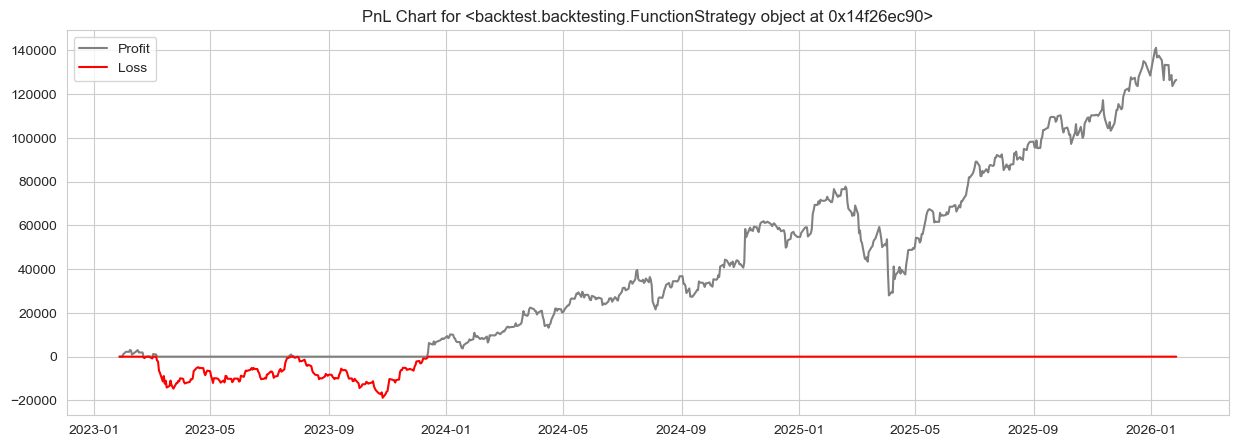

In [9]:
results = btr.VisualiseBacktestResults(backtester, riskfree=0.0)
results.plot_pnl_curve()

Function needs to 
Input: tradable assets; data set; position_history; 
Return: cash , serires: stocks+weights